## Fama-French Regression - Value Weighted
### Import Packages

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import statsmodels.api as sm
import statistics
import sys
sys.path.insert(0, "../")
import util
from importlib import reload
util=reload(util)

### Import Packages

In [2]:
# Number of stocks in Portfolio
nstocks = 50

#Set a start date
StartDate='12/31/1990'

### Import Data
#### Beta Rankings

In [3]:
data = pd.read_csv('qFFdata_better_beta.csv.gz', compression='gzip', usecols=lambda x: x.lower())

data['jdate'] = pd.to_datetime(data['jdate'])

data.head()

,permno,permco,ret,retx,shrcd,exchcd,namedt,nameendt,jdate,retadj,...,month,year,1+retadj,annRet,mktSD,covmktstock,beta,lagbeta,ranklagbeta,lagbetaq
0,10078,8021,-0.267050,-0.267050,11,3,1986-03-04,2004-06-09,2000-12-31,-0.267050,...,12,2000,0.732950,-0.280065,0.013999,0.000376,1.918624,1.822038,1265.0,4
1,10299,8220,-0.022457,-0.022457,11,3,1986-05-28,2004-06-09,2000-12-31,-0.022457,...,12,2000,0.977543,0.294943,0.013999,0.000387,1.973269,1.798183,1259.0,4
2,11896,9698,-0.062500,-0.062500,11,3,1988-02-29,2004-06-09,2000-12-31,-0.062500,...,12,2000,0.937500,0.013245,0.013999,0.000418,2.134560,1.796163,1258.0,4
3,43610,6125,0.092437,0.092437,11,3,1993-07-06,2002-07-15,2000-12-31,0.092437,...,12,2000,1.092437,0.113014,0.013999,0.000413,2.104899,1.890788,1274.0,4
4,43757,6560,0.127869,0.127869,11,3,1993-07-01,2004-06-09,2000-12-31,0.127869,...,12,2000,1.127869,0.755102,0.013999,0.000292,1.487939,2.313234,1296.0,4


In [4]:
data.permno.nunique()

2361

#### Annual Returns Data (includes Jan Effect)

In [5]:
data2 = pd.read_csv('AnnRet.csv.gz', compression='gzip', usecols=lambda x: x.lower())

data2['jdate'] = pd.to_datetime(data2['jdate'])

data2['jdate'] = data2['jdate']+MonthEnd(0)

data2 = data2.drop(columns=['permco','shrcd','exchcd','ret','retx','shrout','prc','dlret','dlstdt','retadj','retxadj','month','year','1+retadj','daycount', 'namedt', 'nameendt'])

data2.head()

,permno,jdate,annRet,annRet10
0,10001,1990-12-31,-0.009264,-0.009264
1,10001,1991-12-31,0.607307,0.650747
2,10001,1992-12-31,0.013423,0.013423
3,10001,1993-12-31,0.371066,0.323788
4,10001,1994-12-31,-0.090405,-0.064961


In [6]:
data3 = pd.merge(data,data2, how ='inner', on = ['permno','jdate'])

data3 = data3.drop(columns = 'annRet_x')

data3 = data3.rename(columns={'annRet_y': 'annRet'})

data3['volRank'] = data3.groupby(['year'])['lagbeta'].rank(ascending=True)

data3.head()

,permno,permco,ret,retx,shrcd,exchcd,namedt,nameendt,jdate,retadj,...,1+retadj,mktSD,covmktstock,beta,lagbeta,ranklagbeta,lagbetaq,annRet,annRet10,volRank
0,10078,8021,-0.267050,-0.267050,11,3,1986-03-04,2004-06-09,2000-12-31,-0.267050,...,0.732950,0.013999,0.000376,1.918624,1.822038,1265.0,4,-0.280066,-0.224348,10.0
1,10299,8220,-0.022457,-0.022457,11,3,1986-05-28,2004-06-09,2000-12-31,-0.022457,...,0.977543,0.013999,0.000387,1.973269,1.798183,1259.0,4,0.295389,0.130503,4.0
2,11896,9698,-0.062500,-0.062500,11,3,1988-02-29,2004-06-09,2000-12-31,-0.062500,...,0.937500,0.013999,0.000418,2.134560,1.796163,1258.0,4,0.013233,-0.040162,3.0
3,43610,6125,0.092437,0.092437,11,3,1993-07-06,2002-07-15,2000-12-31,0.092437,...,1.092437,0.013999,0.000413,2.104899,1.890788,1274.0,4,0.113011,0.218747,19.0
4,43757,6560,0.127869,0.127869,11,3,1993-07-01,2004-06-09,2000-12-31,0.127869,...,1.127869,0.013999,0.000292,1.487939,2.313234,1296.0,4,0.755093,0.801037,41.0


## Create Portfolio Returns
### Value Weighted Returns
#### Jan 1 start date

In [7]:
# For value weighted returns from Jan 1 
returns = data3.copy()

# Select the N stocks with the lowest absolute value of beta for each month
returns = returns[returns['volRank']<=nstocks]

# Create value weighted returns for each period
returns['wret']=returns['annRet']*returns['me']
port1=returns.groupby(['jdate'])['wret'].sum().reset_index(name='vwret')
portnorm1=returns.groupby(['jdate'])['me'].sum().reset_index()
port1['vwret']=port1['vwret']/portnorm1['me']
port1['jdate'] = pd.to_datetime(port1['jdate'])

In [8]:
# For for value weighted returns from Jan 10
returns2 = data3.copy()

# Select the N stocks with the lowest absolute value of beta for each month
returns2 = returns2[returns2['volRank']<=nstocks]

# Create value weighted returns for each period
returns2['wret']=returns2['annRet10']*returns['me']
port2=returns2.groupby(['jdate'])['wret'].sum().reset_index(name='vwret10')
portnorm2=returns2.groupby(['jdate'])['me'].sum().reset_index()
port2['vwret10']=port2['vwret10']/portnorm2['me']
port2['jdate'] = pd.to_datetime(port2['jdate'])

In [9]:
port = pd.merge(port1,port2,on='jdate',how='inner')

### Export Sample Portfolio

In [10]:
port

,jdate,vwret,vwret10
0,2000-12-31,-0.204483,-0.162944
1,2001-12-31,0.051296,-0.014395
2,2002-12-31,-0.453449,-0.511883
3,2003-12-31,0.589581,0.412401
4,2004-12-31,-0.013856,-0.061873
5,2005-12-31,0.043228,0.102080
6,2006-12-31,0.347825,0.258793
7,2007-12-31,0.535347,0.579955
8,2008-12-31,-0.506044,-0.471779
9,2009-12-31,0.852524,0.750216


In [11]:
port.describe()

,vwret,vwret10
count,21.000000,21.000000
mean,0.160163,0.132512
std,0.349394,0.326081
min,-0.506044,-0.511883
25%,-0.022544,-0.061873
50%,0.158222,0.148435
75%,0.369351,0.312137
max,0.852524,0.750216


In [12]:
port.to_csv("vw_sample_port.csv.gz", 
           index=False, 
           compression="gzip")

## Fama-French Factors
### Import Data
#### Fama-French 5 Factors

In [13]:
ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')

ff.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.01,-0.35,0.03,0.11,0.012
1,19630702,0.79,-0.31,0.24,-0.08,-0.25,0.012
2,19630703,0.63,-0.16,-0.09,0.13,-0.24,0.012
3,19630705,0.40,0.09,-0.26,0.07,-0.28,0.012
4,19630708,-0.63,0.07,-0.19,-0.27,0.06,0.012


In [14]:
# Convert Date to an actual date format
ff['date'] = pd.to_datetime(ff['Date'].astype(str), format='%Y%m%d')

ff.head()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,date
0,19630701,-0.67,0.01,-0.35,0.03,0.11,0.012,1963-07-01
1,19630702,0.79,-0.31,0.24,-0.08,-0.25,0.012,1963-07-02
2,19630703,0.63,-0.16,-0.09,0.13,-0.24,0.012,1963-07-03
3,19630705,0.40,0.09,-0.26,0.07,-0.28,0.012,1963-07-05
4,19630708,-0.63,0.07,-0.19,-0.27,0.06,0.012,1963-07-08


In [15]:
# Drop extra variables
ff.drop(['Date'], axis = 1, inplace=True)

In [16]:
# Rename columns
ff.columns = ['MKTRF','SMB','HML','RMW','CMA','RF','date']

ff.head()

,MKTRF,SMB,HML,RMW,CMA,RF,date
0,-0.67,0.01,-0.35,0.03,0.11,0.012,1963-07-01
1,0.79,-0.31,0.24,-0.08,-0.25,0.012,1963-07-02
2,0.63,-0.16,-0.09,0.13,-0.24,0.012,1963-07-03
3,0.40,0.09,-0.26,0.07,-0.28,0.012,1963-07-05
4,-0.63,0.07,-0.19,-0.27,0.06,0.012,1963-07-08


In [17]:
ff['date'] = pd.to_datetime(ff['date'], format='%Y')
ff['date'] = ff['date']+YearEnd(0)
ff = ff.rename(columns={'date':'jdate'})

ff.head()

,MKTRF,SMB,HML,RMW,CMA,RF,jdate
0,-0.67,0.01,-0.35,0.03,0.11,0.012,1963-12-31
1,0.79,-0.31,0.24,-0.08,-0.25,0.012,1963-12-31
2,0.63,-0.16,-0.09,0.13,-0.24,0.012,1963-12-31
3,0.40,0.09,-0.26,0.07,-0.28,0.012,1963-12-31
4,-0.63,0.07,-0.19,-0.27,0.06,0.012,1963-12-31


## Combine Datasets

In [18]:
returnReg = pd.merge(port,ff,how='left',on=['jdate'])

In [19]:
returnReg = returnReg[~(returnReg['jdate']<StartDate)]

In [20]:
# Normalize start date to 0 and convert Ken French data from percent back to number
returnReg['MKTRF']=np.where(returnReg['jdate']==StartDate,0, returnReg['MKTRF']/100)
returnReg['SMB']=np.where(returnReg['jdate']==StartDate,0, returnReg['SMB']/100)
returnReg['HML']=np.where(returnReg['jdate']==StartDate,0, returnReg['HML']/100)
returnReg['RMW']=np.where(returnReg['jdate']==StartDate,0, returnReg['RMW']/100)
returnReg['CMA']=np.where(returnReg['jdate']==StartDate,0, returnReg['CMA']/100)
returnReg['RF']=np.where(returnReg['jdate']==StartDate,0, returnReg['RF']/100)

In [21]:
# Create Excess Returns column
returnReg['XSret'] =  returnReg['vwret']-returnReg['RF']

In [22]:
# Define Fama-French Factors as independent varialbles
# CAPM
X1=sm.add_constant(returnReg[['MKTRF']])
# FF 3-factors
X3=sm.add_constant(returnReg[['MKTRF','SMB','HML']])
# FF 5-factors
X5=sm.add_constant(returnReg[['MKTRF','SMB','HML','RMW','CMA']])

In [23]:
# Define Excess Returns as the dependent variable
Y=returnReg['XSret']

In [24]:
# CAPM (FF 1-factor)
print("1-Factor Regression (CAPM)")
model1F = sm.OLS(Y,X1).fit()
print(model1F.summary())

1-Factor Regression (CAPM)
                            OLS Regression Results                            
Dep. Variable:                  XSret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     12.46
Date:                Mon, 16 May 2022   Prob (F-statistic):           0.000420
Time:                        19:10:39   Log-Likelihood:                -1811.0
No. Observations:                5284   AIC:                             3626.
Df Residuals:                    5282   BIC:                             3639.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1596    

In [25]:
# FF 3-factor
print("Fama-French 3-Factors Regression")
model3F = sm.OLS(Y,X3).fit()
print(model3F.summary())

Fama-French 3-Factors Regression
                            OLS Regression Results                            
Dep. Variable:                  XSret   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.210
Date:                Mon, 16 May 2022   Prob (F-statistic):           0.000331
Time:                        19:10:42   Log-Likelihood:                -1807.9
No. Observations:                5284   AIC:                             3624.
Df Residuals:                    5280   BIC:                             3650.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.15

In [26]:
# FF 5-factor
print("Fama-French 5-Factors Regression")
model5F = sm.OLS(Y,X5).fit()
print(model5F.summary())

Fama-French 5-Factors Regression
                            OLS Regression Results                            
Dep. Variable:                  XSret   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.914
Date:                Mon, 16 May 2022   Prob (F-statistic):           0.000173
Time:                        19:10:44   Log-Likelihood:                -1805.0
No. Observations:                5284   AIC:                             3622.
Df Residuals:                    5278   BIC:                             3661.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.16

In [ ]:
# Plot residuals


## Sector Allocation
### Import Data
#### Industry Codes

In [3]:
industry = pd.read_csv('IndustryCodes.csv.gz', compression='gzip', usecols=lambda x: x.lower())

industry.head()

,permno,comnam,cusip,ticker,siccd,sicdate,indCode,industry,indDesc,enddate
0,14322.0,SEARS ROEBUCK & CO,81238710,NaN,5320.0,1925-12-31,9,Shops,"Wholesale, Retail, and Some Services (Laundrie...",1962-07-31 00:00:00.000000
1,13936.0,PHILLIPS JONES CORP,69365610,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1957-08-31 00:00:00.000000
2,13290.0,MUNSINGWEAR INC,74090910,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1962-07-31 00:00:00.000000
3,14998.0,UNITED RYS INVT CO,91199190,NaN,6150.0,1925-12-31,11,Money,Finance,2021-11-14 20:13:50.211097
4,13012.0,MANHATTAN SHIRT CO,56287610,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1962-07-31 00:00:00.000000


In [4]:
industry['sicdate'] = pd.to_datetime(industry['sicdate'])
industry['enddate'] = pd.to_datetime(industry['enddate'])

In [29]:
returns2 = pd.merge(returns,industry,how='left',on=['permno'])

In [30]:
returns3 = returns2[(returns2['jdate']>=returns2['sicdate'])&(returns2['jdate']<=returns2['enddate'])]

In [31]:
industry = pd.DataFrame(columns=['indCode','industry','indDesc'])
industry = industry.append({'indCode':1,'industry':"NoDur",'indDesc':"Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys"},ignore_index=True)
industry = industry.append({'indCode':2,'industry':"Durbl",'indDesc':"Consumer Durables -- Cars, TVs, Furniture, Household Appliances"},ignore_index=True)
industry = industry.append({'indCode':3,'industry':"Manuf",'indDesc':"Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing"},ignore_index=True)
industry = industry.append({'indCode':4,'industry':"Enrgy",'indDesc':"Oil, Gas, and Coal Extraction and Products"},ignore_index=True)
industry = industry.append({'indCode':5,'industry':"Chems",'indDesc':"Chemicals and Allied Products"},ignore_index=True)
industry = industry.append({'indCode':6,'industry':"BusEq",'indDesc':"Business Equipment -- Computers, Software, and Electronic Equipment"},ignore_index=True)
industry = industry.append({'indCode':7,'industry':"Telcm",'indDesc':"Telephone and Television Transmission"},ignore_index=True)
industry = industry.append({'indCode':8,'industry':"Utils",'indDesc':"Utilities"},ignore_index=True)
industry = industry.append({'indCode':9,'industry':"Shops",'indDesc':"Wholesale, Retail, and Some Services (Laundries, Repair Shops)"},ignore_index=True)
industry = industry.append({'indCode':10,'industry':"Hlth",'indDesc':"Healthcare, Medical Equipment, and Drugs"},ignore_index=True)
industry = industry.append({'indCode':11,'industry':"Money",'indDesc':"Finance"},ignore_index=True)
industry = industry.append({'indCode':12,'industry':"Other",'indDesc':"Other -- Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment"},ignore_index=True)

In [32]:
indCodes = pd.DataFrame(columns=['year','indCode','industry','weight (%)'])

for year in range(1990,2021):
    for ind in range(1,13):
        wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
        indName = industry.loc[ind-1,'industry']
        
        indCodes = indCodes.append({'year':year,
                                    'indCode':ind,
                                    'industry':indName,
                                    'weight (%)':wt},
                                    ignore_index=True)

indCodes['year'] = indCodes['year'].astype(int)
indCodes['indCode'] = indCodes['indCode'].astype(int)

<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: inval

<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: inval

<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: invalid value encountered in double_scalars
  wt = round((returns3[(returns3['year']==year)&(returns3['indCode']==ind)]['me'].sum()/returns3[returns3['year']==year]['me'].sum())*100,3)
<ipython-input-32-327537f41d48>:5: RuntimeWarning: inval

In [33]:
indCodes.groupby(['industry'])['weight (%)'].mean()

industry
BusEq    32.132048
Chems     4.578857
Durbl     4.174095
Enrgy     4.975524
Hlth      5.262381
Manuf     9.085905
Money    21.480476
NoDur     0.471286
Other    13.650667
Shops     2.628095
Telcm     1.462048
Utils     0.098905
Name: weight (%), dtype: float64

In [34]:
indCodes[indCodes['year']==2020]

,year,indCode,industry,weight (%)
360,2020,1,NoDur,0.000
361,2020,2,Durbl,1.584
362,2020,3,Manuf,3.401
363,2020,4,Enrgy,0.247
364,2020,5,Chems,7.617
365,2020,6,BusEq,38.048
366,2020,7,Telcm,0.068
367,2020,8,Utils,0.000
368,2020,9,Shops,2.643
369,2020,10,Hlth,13.742


In [35]:
indCodes = indCodes.replace(np.nan, 0)

### All Industries Plot

In [36]:
x = indCodes[indCodes['indCode']==6]['year']
y1 = indCodes[indCodes['indCode']==1]['weight (%)']
y2 = indCodes[indCodes['indCode']==2]['weight (%)']
y3 = indCodes[indCodes['indCode']==3]['weight (%)']
y4 = indCodes[indCodes['indCode']==4]['weight (%)']
y5 = indCodes[indCodes['indCode']==5]['weight (%)']
y6 = indCodes[indCodes['indCode']==6]['weight (%)']
y7 = indCodes[indCodes['indCode']==7]['weight (%)']
y8 = indCodes[indCodes['indCode']==8]['weight (%)']
y9 = indCodes[indCodes['indCode']==9]['weight (%)']
y10 = indCodes[indCodes['indCode']==10]['weight (%)']
y11 = indCodes[indCodes['indCode']==11]['weight (%)']
y12 = indCodes[indCodes['indCode']==12]['weight (%)']

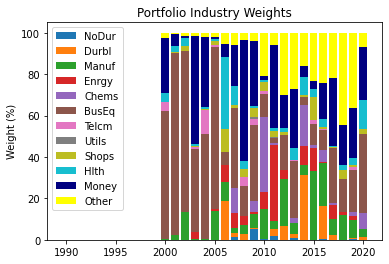

In [37]:
# Plot bars in stack manner
plt.bar(x, y1, color='tab:blue')
plt.bar(x, y2, bottom=y1, color='tab:orange')
plt.bar(x, y3, bottom=tuple(map(sum,zip(y1, y2))), color='tab:green')
plt.bar(x, y4, bottom=tuple(map(sum,zip(y1, y2, y3))), color='tab:red')
plt.bar(x, y5, bottom=tuple(map(sum,zip(y1, y2, y3, y4))), color='tab:purple')
plt.bar(x, y6, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5))), color='tab:brown')
plt.bar(x, y7, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6))), color='tab:pink')
plt.bar(x, y8, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7))), color='tab:gray')
plt.bar(x, y9, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8))), color='tab:olive')
plt.bar(x, y10, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8, y9))), color='tab:cyan')
plt.bar(x, y11, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))), color='navy')
plt.bar(x, y12, bottom=tuple(map(sum,zip(y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11))), color='yellow')

plt.legend(["NoDur", "Durbl", "Manuf", "Enrgy", "Chems", "BusEq", "Telcm", "Utils", "Shops", "Hlth", "Money", "Other"])
plt.ylabel('Weight (%)')
plt.title('Portfolio Industry Weights')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.show()

### Export Data

In [38]:
indCodes.to_csv('vw_indCodes.csv')

In [39]:
indCodes.columns

Index(['year', 'indCode', 'industry', 'weight (%)'], dtype='object')

### 2020 Portfolio

In [40]:
port20 = returns[returns['year']==2020]

In [41]:
port20 = port20.drop(columns=['permco','shrcd','exchcd','ret','retx','retadj','retxadj','month','year','1+retadj'])

In [42]:
port20['wt'] = port20['me']/port20['me'].sum()

#### Read Back in Industry

In [5]:
industry = pd.read_csv('IndustryCodes.csv.gz', compression='gzip', usecols=lambda x: x.lower())

industry.head()

,permno,comnam,cusip,ticker,siccd,sicdate,indCode,industry,indDesc,enddate
0,14322.0,SEARS ROEBUCK & CO,81238710,NaN,5320.0,1925-12-31,9,Shops,"Wholesale, Retail, and Some Services (Laundrie...",1962-07-31 00:00:00.000000
1,13936.0,PHILLIPS JONES CORP,69365610,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1957-08-31 00:00:00.000000
2,13290.0,MUNSINGWEAR INC,74090910,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1962-07-31 00:00:00.000000
3,14998.0,UNITED RYS INVT CO,91199190,NaN,6150.0,1925-12-31,11,Money,Finance,2021-11-14 20:13:50.211097
4,13012.0,MANHATTAN SHIRT CO,56287610,NaN,2310.0,1925-12-31,1,NoDur,"Consumer NonDurables -- Food, Tobacco, Textile...",1962-07-31 00:00:00.000000


In [6]:
industry[industry['comnam']=='CITIGROUP INC'].head()

,permno,comnam,cusip,ticker,siccd,sicdate,indCode,industry,indDesc,enddate
43688,70519.0,CITIGROUP INC,17296742,CCI,6331.0,1998-10-31,11,Money,Finance,1998-12-31 00:00:00.000000
43875,70519.0,CITIGROUP INC,17296742,C,6153.0,1998-12-31,11,Money,Finance,2000-06-30 00:00:00.000000
46963,70519.0,CITIGROUP INC,17296742,C,6211.0,2000-06-30,11,Money,Finance,2002-01-31 00:00:00.000000
50084,70519.0,CITIGROUP INC,17296742,C,6211.0,2002-01-31,11,Money,Finance,2002-02-28 00:00:00.000000
51890,70519.0,CITIGROUP INC,17296742,C,6021.0,2002-02-28,11,Money,Finance,2004-06-30 00:00:00.000000


In [7]:
industry[industry['comnam']=='SERVICENOW INC'].head()

,permno,comnam,cusip,ticker,siccd,sicdate,indCode,industry,indDesc,enddate
67045,13447.0,SERVICENOW INC,81762P10,NOW,7373.0,2012-06-30,6,BusEq,"Business Equipment -- Computers, Software, and...",2014-01-31 00:00:00.000000
67944,13447.0,SERVICENOW INC,81762P10,NOW,8748.0,2014-01-31,12,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",2017-04-30 00:00:00.000000
70056,13447.0,SERVICENOW INC,81762P10,NOW,7372.0,2017-04-30,6,BusEq,"Business Equipment -- Computers, Software, and...",2017-06-30 00:00:00.000000
70181,13447.0,SERVICENOW INC,81762P10,NOW,8999.0,2017-06-30,12,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",2017-07-31 00:00:00.000000
70217,13447.0,SERVICENOW INC,81762P10,NOW,8999.0,2017-07-31,12,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ...",2019-11-30 00:00:00.000000


In [44]:
industry['sicdate'] = pd.to_datetime(industry['sicdate'])
industry['enddate'] = pd.to_datetime(industry['enddate'])

In [45]:
industry['permno'] = industry['permno'].astype(int)

## Portfolio Construction

In [46]:
port20 = pd.merge(port20,industry,how='left',on=['permno'])

In [47]:
port20.head()

,permno,namedt,nameendt,jdate,me,mktSD,covmktstock,beta,lagbeta,ranklagbeta,...,wt,comnam,cusip,ticker,siccd,sicdate,indCode,industry,indDesc,enddate
0,11403,2019-09-12,2021-09-30,2020-12-31,3.806042e+07,0.02169,0.000514,1.093144,1.499733,1305.0,...,0.063888,ECAD INC,12738710,ECAD,7370.0,1987-06-30,6,BusEq,"Business Equipment -- Computers, Software, and...",1988-06-30
1,11403,2019-09-12,2021-09-30,2020-12-31,3.806042e+07,0.02169,0.000514,1.093144,1.499733,1305.0,...,0.063888,CADENCE DESIGN SYSTEMS INC,12738710,CDNC,7370.0,1988-06-30,6,BusEq,"Business Equipment -- Computers, Software, and...",1990-09-30
2,11403,2019-09-12,2021-09-30,2020-12-31,3.806042e+07,0.02169,0.000514,1.093144,1.499733,1305.0,...,0.063888,CADENCE DESIGN SYSTEMS INC,12738710,CDN,7372.0,1990-09-30,6,BusEq,"Business Equipment -- Computers, Software, and...",2002-01-31
3,11403,2019-09-12,2021-09-30,2020-12-31,3.806042e+07,0.02169,0.000514,1.093144,1.499733,1305.0,...,0.063888,CADENCE DESIGN SYSTEMS INC,12738710,CDN,7372.0,2002-01-31,6,BusEq,"Business Equipment -- Computers, Software, and...",2004-06-30
4,11403,2019-09-12,2021-09-30,2020-12-31,3.806042e+07,0.02169,0.000514,1.093144,1.499733,1305.0,...,0.063888,CADENCE DESIGN SYSTEMS INC,12738710,CDN,7372.0,2004-06-30,6,BusEq,"Business Equipment -- Computers, Software, and...",2004-07-31


In [48]:
port20.columns

Index(['permno', 'namedt', 'nameendt', 'jdate', 'me', 'mktSD', 'covmktstock',
       'beta', 'lagbeta', 'ranklagbeta', 'lagbetaq', 'annRet', 'annRet10',
       'volRank', 'wret', 'wt', 'comnam', 'cusip', 'ticker', 'siccd',
       'sicdate', 'indCode', 'industry', 'indDesc', 'enddate'],
      dtype='object')

In [49]:
port20 = port20[(port20['jdate']>=port20['sicdate'])&(port20['jdate']<=port20['enddate'])]

In [50]:
port20 = port20.drop(columns=['siccd','sicdate','mktSD','covmktstock','enddate','indCode']).drop_duplicates()

In [51]:
port20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 8 to 249
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   permno       50 non-null     int64         
 1   namedt       50 non-null     object        
 2   nameendt     50 non-null     object        
 3   jdate        50 non-null     datetime64[ns]
 4   me           50 non-null     float64       
 5   beta         50 non-null     float64       
 6   lagbeta      50 non-null     float64       
 7   ranklagbeta  50 non-null     float64       
 8   lagbetaq     50 non-null     int64         
 9   annRet       50 non-null     float64       
 10  annRet10     50 non-null     float64       
 11  volRank      50 non-null     float64       
 12  wret         50 non-null     float64       
 13  wt           50 non-null     float64       
 14  comnam       50 non-null     object        
 15  cusip        50 non-null     object        
 16  ticker   

In [52]:
port20.head()

,permno,namedt,nameendt,jdate,me,beta,lagbeta,ranklagbeta,lagbetaq,annRet,annRet10,volRank,wret,wt,comnam,cusip,ticker,industry,indDesc
8,11403,2019-09-12,2021-09-30,2020-12-31,3.806042e+07,1.093144,1.499733,1305.0,4,0.966969,0.859722,50.0,3.680326e+07,0.063888,CADENCE DESIGN SYSTEMS INC,12738710,CDNS,BusEq,"Business Equipment -- Computers, Software, and..."
23,11581,2020-01-29,2021-09-30,2020-12-31,1.352666e+06,1.143430,1.471627,1262.0,4,-0.129493,-0.105083,7.0,-1.751613e+05,0.002271,ENERPAC TOOL GROUP CORP,29276510,EPAC,Manuf,"Manufacturing -- Machinery, Trucks, Planes, Of..."
39,12570,2020-11-18,2021-09-30,2020-12-31,6.654528e+06,1.239906,1.477333,1274.0,4,0.054229,0.071777,19.0,3.608713e+05,0.011170,I T T INC,45073V10,ITT,Manuf,"Manufacturing -- Machinery, Trucks, Planes, Of..."
41,12641,2014-01-09,2021-09-30,2020-12-31,5.054063e+06,1.529928,1.474086,1265.0,4,-0.043432,-0.039998,10.0,-2.195069e+05,0.008484,AIR LEASE CORP,00912X30,AL,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ..."
47,13447,2019-11-21,2021-09-30,2020-12-31,1.073889e+08,1.029737,1.488066,1288.0,4,0.949659,0.838989,33.0,1.019828e+08,0.180261,SERVICENOW INC,81762P10,NOW,BusEq,"Business Equipment -- Computers, Software, and..."


### Export

In [53]:
port20.to_csv('vw_port20.csv')

In [54]:
# Sort by weight (wt) and print top 10
port20_sort = port20.sort_values(['wt'], ascending=[False])
port20_sort.head(10)

,permno,namedt,nameendt,jdate,me,beta,lagbeta,ranklagbeta,lagbetaq,annRet,annRet10,volRank,wret,wt,comnam,cusip,ticker,industry,indDesc
131,70519,2019-09-30,2021-09-30,2020-12-31,1.283737e+08,1.538265,1.484136,1284.0,4,-0.196398,-0.198305,29.0,-2.521234e+07,0.215486,CITIGROUP INC,17296742,C,Money,Finance
47,13447,2019-11-21,2021-09-30,2020-12-31,1.073889e+08,1.029737,1.488066,1288.0,4,0.949659,0.838989,33.0,1.019828e+08,0.180261,SERVICENOW INC,81762P10,NOW,BusEq,"Business Equipment -- Computers, Software, and..."
213,88860,2020-02-14,2021-09-30,2020-12-31,4.214121e+07,1.372698,1.479933,1280.0,4,0.915054,0.802040,25.0,3.856149e+07,0.070737,ALIGN TECHNOLOGY INC,01625510,ALGN,Hlth,"Healthcare, Medical Equipment, and Drugs"
80,18428,2019-12-23,2021-09-30,2020-12-31,4.116724e+07,1.315227,1.477246,1272.0,4,0.080128,0.132695,17.0,3.298628e+06,0.069103,DOW INC,26055710,DOW,Chems,Chemicals and Allied Products
8,11403,2019-09-12,2021-09-30,2020-12-31,3.806042e+07,1.093144,1.499733,1305.0,4,0.966969,0.859722,50.0,3.680326e+07,0.063888,CADENCE DESIGN SYSTEMS INC,12738710,CDNS,BusEq,"Business Equipment -- Computers, Software, and..."
50,14231,2013-10-16,2021-09-30,2020-12-31,3.712728e+07,0.822873,1.489988,1293.0,4,0.935517,0.868305,38.0,3.473319e+07,0.062321,VEEVA SYSTEMS INC,92247510,VEEV,BusEq,"Business Equipment -- Computers, Software, and..."
173,83111,2011-02-10,2021-07-20,2020-12-31,3.434905e+07,0.726154,1.468218,1256.0,4,0.444651,0.410862,1.0,1.527333e+07,0.057658,ALEXION PHARMACEUTICALS INC,01535110,ALXN,Hlth,"Healthcare, Medical Equipment, and Drugs"
60,14641,2019-08-05,2021-09-30,2020-12-31,1.669881e+07,1.075253,1.473610,1263.0,4,0.867682,0.763437,8.0,1.448926e+07,0.028030,ZENDESK INC,98936J10,ZEN,BusEq,"Business Equipment -- Computers, Software, and..."
233,92257,2019-09-12,2021-09-30,2020-12-31,1.578710e+07,0.889934,1.474285,1267.0,4,-0.075957,-0.076019,12.0,-1.199148e+06,0.026500,VMWARE INC,92856340,VMW,BusEq,"Business Equipment -- Computers, Software, and..."
57,14596,2014-04-04,2021-03-28,2020-12-31,1.159411e+07,0.695435,1.468458,1257.0,4,1.659333,1.449254,2.0,1.923849e+07,0.019462,FIVE 9 INC,33830710,FIVN,Other,"Other -- Mines, Constr, BldMt, Trans, Hotels, ..."


In [58]:
port20_sort_name = port20_sort[['comnam', 'wt', 'beta', 'lagbeta', 'annRet']]
port20_sort_name.columns = (['Company', 'Weight', 'Beta', 'Lag Beta', 'Annual Return'])

port20_sort_name.head(10)

,Company,Weight,Lag Beta,Beta,Annual Return
131,CITIGROUP INC,0.215486,1.484136,1.538265,-0.196398
47,SERVICENOW INC,0.180261,1.488066,1.029737,0.949659
213,ALIGN TECHNOLOGY INC,0.070737,1.479933,1.372698,0.915054
80,DOW INC,0.069103,1.477246,1.315227,0.080128
8,CADENCE DESIGN SYSTEMS INC,0.063888,1.499733,1.093144,0.966969
50,VEEVA SYSTEMS INC,0.062321,1.489988,0.822873,0.935517
173,ALEXION PHARMACEUTICALS INC,0.057658,1.468218,0.726154,0.444651
60,ZENDESK INC,0.028030,1.473610,1.075253,0.867682
233,VMWARE INC,0.026500,1.474285,0.889934,-0.075957
57,FIVE 9 INC,0.019462,1.468458,0.695435,1.659333


In [59]:
port20_sort_name

,Company,Weight,Lag Beta,Beta,Annual Return
131,CITIGROUP INC,0.215486,1.484136,1.538265,-0.196398
47,SERVICENOW INC,0.180261,1.488066,1.029737,0.949659
213,ALIGN TECHNOLOGY INC,0.070737,1.479933,1.372698,0.915054
80,DOW INC,0.069103,1.477246,1.315227,0.080128
8,CADENCE DESIGN SYSTEMS INC,0.063888,1.499733,1.093144,0.966969
50,VEEVA SYSTEMS INC,0.062321,1.489988,0.822873,0.935517
173,ALEXION PHARMACEUTICALS INC,0.057658,1.468218,0.726154,0.444651
60,ZENDESK INC,0.028030,1.473610,1.075253,0.867682
233,VMWARE INC,0.026500,1.474285,0.889934,-0.075957
57,FIVE 9 INC,0.019462,1.468458,0.695435,1.659333
